ASSIGNMENT 4 - HEART DISEASE CLASSIFICATION TREE

## 1.1 Data Cleaning

In [3]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [5]:
# Cargar el dataset
url <- 'processed.cleveland.data'

column_names <- c('age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg',
                  'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd')

# Leer los datos
df <- read.csv(url, header = FALSE, col.names = column_names,
               na.strings = "?", stringsAsFactors = FALSE)

cat("\n✓ Dataset cargado exitosamente\n")
cat("  Dimensiones originales:", dim(df)[1], "filas x", dim(df)[2], "columnas\n")

# Remover valores faltantes
df_clean <- na.omit(df)

cat("\n✓ Valores faltantes removidos\n")
cat("  Nuevas dimensiones:", dim(df_clean)[1], "filas x", dim(df_clean)[2], "columnas\n")
cat("  Filas removidas:", dim(df)[1] - dim(df_clean)[1], "\n")

# Identificar variables categóricas
categorical_vars <- c('sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal')

# Convertir variables categóricas a factores
df_clean[categorical_vars] <- lapply(df_clean[categorical_vars], as.factor)

# Crear variables dummy
numeric_vars <- c('age', 'restbp', 'chol', 'thalach', 'oldpeak')

# Crear fórmula solo con variables categóricas
formula_cat <- as.formula(paste("~", paste(categorical_vars, collapse = " + "), "- 1"))
dummy_matrix <- model.matrix(formula_cat, data = df_clean)

# Combinar variables numéricas con dummies
df_dummies <- data.frame(
  df_clean[numeric_vars],
  dummy_matrix,
  hd = df_clean$hd
)

cat("\n✓ Variables categóricas convertidas a dummies\n")
cat("  Nuevas dimensiones después de codificación dummy:",
    dim(df_dummies)[1], "filas x", dim(df_dummies)[2], "columnas\n")

# Crear variable binaria y
y <- as.integer(df_dummies$hd > 0)
X <- df_dummies %>% select(-hd)

cat("\n✓ Variable objetivo binaria creada\n")
cat("  Distribución de clases:\n")
cat("    Sin enfermedad cardíaca (y=0):", sum(y == 0),
    sprintf("(%.1f%%)\n", sum(y == 0) / length(y) * 100))
cat("    Con enfermedad cardíaca (y=1):", sum(y == 1),
    sprintf("(%.1f%%)\n", sum(y == 1) / length(y) * 100))



✓ Dataset cargado exitosamente
  Dimensiones originales: 303 filas x 14 columnas

✓ Valores faltantes removidos
  Nuevas dimensiones: 297 filas x 14 columnas
  Filas removidas: 6 

✓ Variables categóricas convertidas a dummies
  Nuevas dimensiones después de codificación dummy: 297 filas x 22 columnas

✓ Variable objetivo binaria creada
  Distribución de clases:
    Sin enfermedad cardíaca (y=0): 160 (53.9%)
    Con enfermedad cardíaca (y=1): 137 (46.1%)


## 1.2 Data Analysis

In [7]:
install.packages("rpart.plot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [8]:
library(rpart)
library(rpart.plot)
library(ggplot2)



[1] Dividiendo datos en conjuntos de entrenamiento y prueba...
  Tamaño del conjunto de entrenamiento: 207 
  Tamaño del conjunto de prueba: 90 

[2] Entrenando árbol de clasificación inicial...

✓ Graficando árbol de clasificación inicial


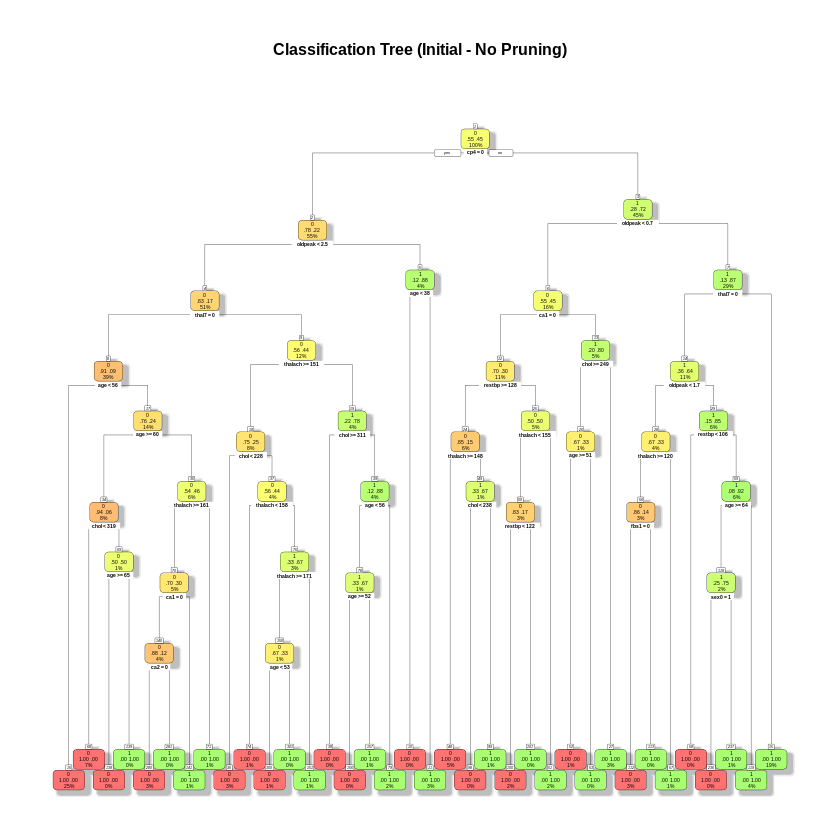

In [9]:
# 1. Split data into training and test sets, and plot a classification tree

cat("\n[1] Dividiendo datos en conjuntos de entrenamiento y prueba...\n")

set.seed(123)
train_index <- sample(1:nrow(X), size = 0.7 * nrow(X))
X_train <- X[train_index, ]
X_test <- X[-train_index, ]
y_train <- y[train_index]
y_test <- y[-train_index]

cat("  Tamaño del conjunto de entrenamiento:", nrow(X_train), "\n")
cat("  Tamaño del conjunto de prueba:", nrow(X_test), "\n")

# Crear dataframe para entrenamiento
train_data <- data.frame(X_train, hd = as.factor(y_train))
test_data <- data.frame(X_test, hd = as.factor(y_test))

# Entrenar árbol de clasificación sin poda (cp = 0)
cat("\n[2] Entrenando árbol de clasificación inicial...\n")
tree_initial <- rpart(hd ~ .,
                      data = train_data,
                      method = "class",
                      cp = 0,
                      minsplit = 2,
                      minbucket = 1)

# Graficar árbol inicial
cat("\n✓ Graficando árbol de clasificación inicial\n")
rpart.plot(tree_initial,
           main = "Classification Tree (Initial - No Pruning)",
           extra = 104,
           box.palette = "RdYlGn",
           shadow.col = "gray",
           nn = TRUE)


[3] Generando matriz de confusión...

Interpretación de la Matriz de Confusión:
- Verdaderos Negativos (TN): 31 - Pacientes sin HD correctamente clasificados
- Falsos Positivos (FP): 12 - Pacientes sin HD clasificados como con HD
- Falsos Negativos (FN): 15 - Pacientes con HD clasificados como sin HD
- Verdaderos Positivos (TP): 32 - Pacientes con HD correctamente clasificados


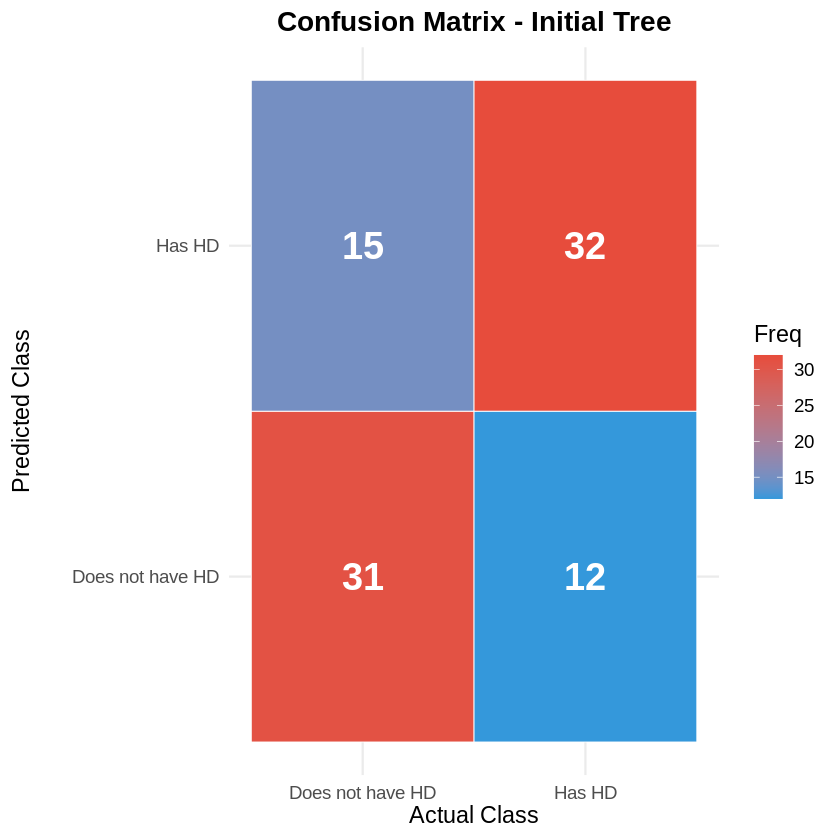

In [13]:
# 2 Confusion Matrix
cat("\n[3] Generando matriz de confusión...\n")

# Predicciones en el conjunto de prueba
y_pred_initial <- predict(tree_initial, test_data, type = "class")

# Crear matriz de confusión
conf_matrix <- table(Predicted = y_pred_initial, Actual = y_test)

# Calcular accuracy
accuracy_initial <- sum(diag(conf_matrix)) / sum(conf_matrix)

# Graficar
conf_df <- as.data.frame(conf_matrix)
colnames(conf_df) <- c("Predicted", "Actual", "Freq")
conf_df$Predicted <- factor(conf_df$Predicted, levels = c(0, 1),
                            labels = c("Does not have HD", "Has HD"))
conf_df$Actual <- factor(conf_df$Actual, levels = c(0, 1),
                         labels = c("Does not have HD", "Has HD"))

ggplot(conf_df, aes(x = Actual, y = Predicted, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), size = 8, color = "white", fontface = "bold") +
  scale_fill_gradient(low = "#3498db", high = "#e74c3c") +
  labs(title = "Confusion Matrix - Initial Tree",
       x = "Actual Class",
       y = "Predicted Class") +
  theme_minimal(base_size = 14) +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "right")

# Interpretación
cat("\nInterpretación de la Matriz de Confusión:\n")
cat("- Verdaderos Negativos (TN):", conf_matrix[1,1], "- Pacientes sin HD correctamente clasificados\n")
cat("- Falsos Positivos (FP):", conf_matrix[1,2], "- Pacientes sin HD clasificados como con HD\n")
cat("- Falsos Negativos (FN):", conf_matrix[2,1], "- Pacientes con HD clasificados como sin HD\n")
cat("- Verdaderos Positivos (TP):", conf_matrix[2,2], "- Pacientes con HD correctamente clasificados\n")


In [14]:
# 3. Fixing overfitting using cross-validation...
cat("\n[4] Realizando validación cruzada para encontrar α óptimo...\n")

# Generar 50 valores de alpha en escala logarítmica
alpha_values <- exp(seq(log(exp(-10)), log(0.05), length.out = 50))

# Función para calcular accuracy con cross-validation
set.seed(123)
n_folds <- 4
fold_ids <- sample(rep(1:n_folds, length.out = nrow(train_data)))

# Almacenar resultados
cv_results <- data.frame(alpha = alpha_values,
                         mean_accuracy = numeric(50),
                         inaccuracy_rate = numeric(50))

cat("  Probando", length(alpha_values), "valores de α con validación cruzada de 4 folds...\n")

for (i in 1:length(alpha_values)) {
  accuracies <- numeric(n_folds)

  for (fold in 1:n_folds) {
    # Dividir en train y validation
    val_indices <- which(fold_ids == fold)
    train_fold <- train_data[-val_indices, ]
    val_fold <- train_data[val_indices, ]

    # Entrenar modelo con alpha actual
    tree_cv <- rpart(hd ~ .,
                     data = train_fold,
                     method = "class",
                     cp = alpha_values[i])

    # Predecir y calcular accuracy
    pred_cv <- predict(tree_cv, val_fold, type = "class")
    accuracies[fold] <- mean(pred_cv == val_fold$hd)
  }

  cv_results$mean_accuracy[i] <- mean(accuracies)
  cv_results$inaccuracy_rate[i] <- 1 - mean(accuracies)

  if (i %% 10 == 0) {
    cat("  Progreso:", i, "/", length(alpha_values), "\n")
  }
}

# Encontrar alpha óptimo
optimal_idx <- which.min(cv_results$inaccuracy_rate)
optimal_alpha <- cv_results$alpha[optimal_idx]
optimal_inaccuracy <- cv_results$inaccuracy_rate[optimal_idx]

cat("\n✓ α óptimo encontrado:", sprintf("%.6f", optimal_alpha), "\n")
cat("  Tasa de Inaccuracy (validación cruzada):", sprintf("%.4f", optimal_inaccuracy), "\n")


[4] Realizando validación cruzada para encontrar α óptimo...
  Probando 50 valores de α con validación cruzada de 4 folds...
  Progreso: 10 / 50 
  Progreso: 20 / 50 
  Progreso: 30 / 50 
  Progreso: 40 / 50 
  Progreso: 50 / 50 

✓ α óptimo encontrado: 0.015934 
  Tasa de Inaccuracy (validación cruzada): 0.2562 



[5] Graficando Tasa de Inaccuracy vs α...


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


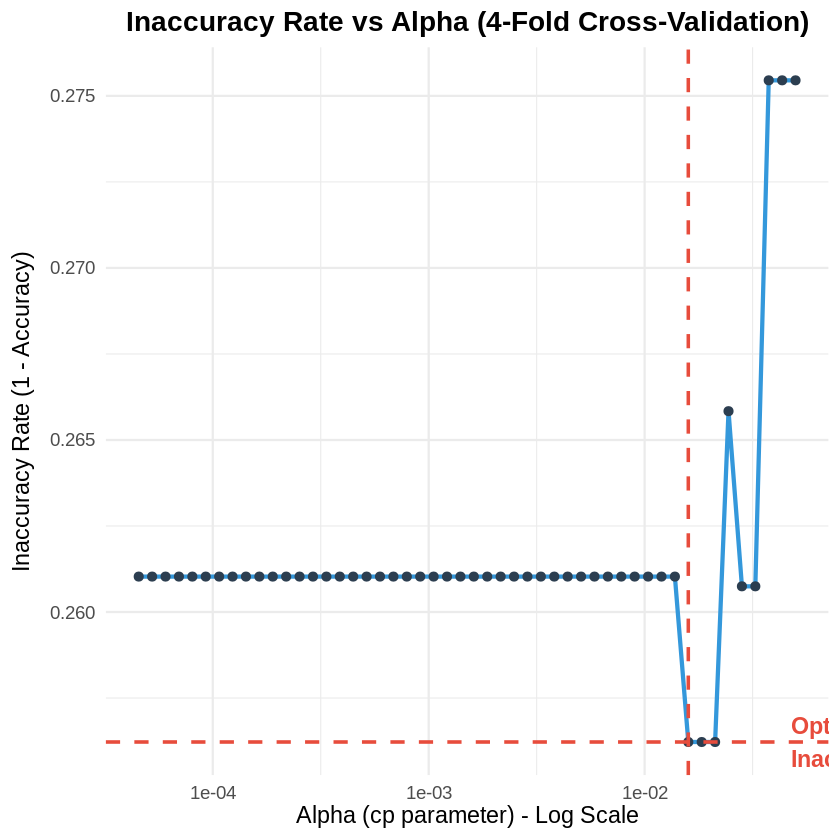

In [15]:
# 4. Plot Inaccuracy Rate vs Alpha
cat("\n[5] Graficando Tasa de Inaccuracy vs α...\n")

ggplot(cv_results, aes(x = alpha, y = inaccuracy_rate)) +
  geom_line(color = "#3498db", size = 1.2) +
  geom_point(color = "#2c3e50", size = 2) +
  geom_vline(xintercept = optimal_alpha, linetype = "dashed",
             color = "#e74c3c", size = 1) +
  geom_hline(yintercept = optimal_inaccuracy, linetype = "dashed",
             color = "#e74c3c", size = 1) +
  annotate("text", x = optimal_alpha * 3, y = optimal_inaccuracy,
           label = sprintf("Optimal α = %.6f\nInaccuracy = %.4f",
                          optimal_alpha, optimal_inaccuracy),
           hjust = 0, color = "#e74c3c", fontface = "bold") +
  scale_x_log10() +
  labs(title = "Inaccuracy Rate vs Alpha (4-Fold Cross-Validation)",
       x = "Alpha (cp parameter) - Log Scale",
       y = "Inaccuracy Rate (1 - Accuracy)") +
  theme_minimal(base_size = 14) +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))



[6] Entrenando árbol final con α óptimo...

✓ Graficando árbol de clasificación óptimo

✓ Matriz de Confusión (Árbol Óptimo - Conjunto de Prueba):

                 Actual
Predicted    Does not have HD    Has HD
Does not have HD    42              18
Has HD              4              26

Accuracy: 0.7556 


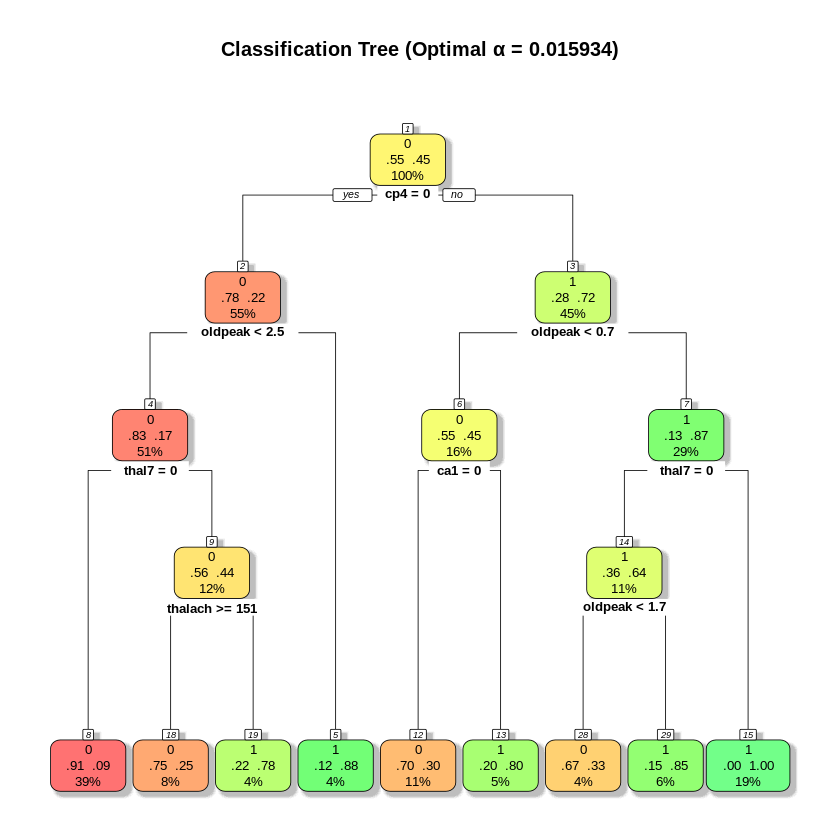

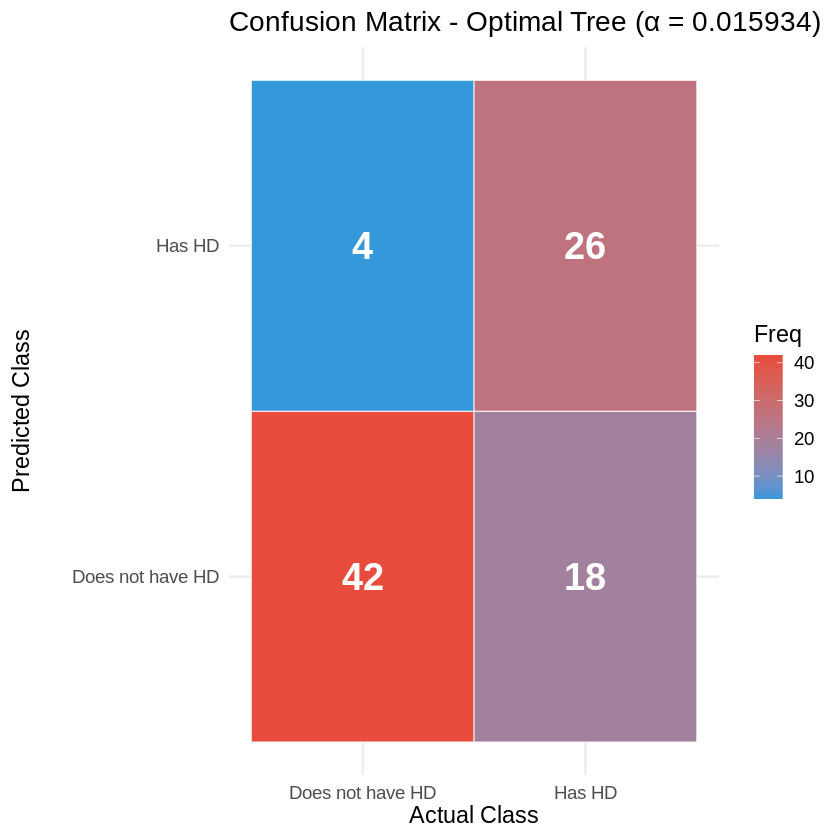

In [18]:

# 5. Final tree with optimal alpha
cat("\n[6] Entrenando árbol final con α óptimo...\n")

tree_optimal <- rpart(hd ~ .,
                      data = train_data,
                      method = "class",
                      cp = optimal_alpha)

# Graficar árbol óptimo
cat("\n✓ Graficando árbol de clasificación óptimo\n")
rpart.plot(tree_optimal,
           main = sprintf("Classification Tree (Optimal α = %.6f)", optimal_alpha),
           extra = 104,
           box.palette = "RdYlGn",
           shadow.col = "gray",
           nn = TRUE)

# Predicciones con árbol óptimo
y_pred_optimal <- predict(tree_optimal, test_data, type = "class")

# Matriz de confusión para árbol óptimo
conf_matrix_optimal <- table(Predicted = y_pred_optimal, Actual = y_test)
accuracy_optimal <- sum(diag(conf_matrix_optimal)) / sum(conf_matrix_optimal)

cat("\n✓ Matriz de Confusión (Árbol Óptimo - Conjunto de Prueba):\n")
cat("\n                 Actual\n")
cat("Predicted    Does not have HD    Has HD\n")
cat(sprintf("Does not have HD    %d              %d\n",
            conf_matrix_optimal[1,1], conf_matrix_optimal[1,2]))
cat(sprintf("Has HD              %d              %d\n",
            conf_matrix_optimal[2,1], conf_matrix_optimal[2,2]))
cat("\nAccuracy:", sprintf("%.4f", accuracy_optimal), "\n")

# Graficar matriz de confusión óptima
conf_df_optimal <- as.data.frame(conf_matrix_optimal)
colnames(conf_df_optimal) <- c("Predicted", "Actual", "Freq")
conf_df_optimal$Predicted <- factor(conf_df_optimal$Predicted, levels = c(0, 1),
                                    labels = c("Does not have HD", "Has HD"))
conf_df_optimal$Actual <- factor(conf_df_optimal$Actual, levels = c(0, 1),
                                 labels = c("Does not have HD", "Has HD"))

ggplot(conf_df_optimal, aes(x = Actual, y = Predicted, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), size = 8, color = "white", fontface = "bold") +
  scale_fill_gradient(low = "#3498db", high = "#e74c3c") +
  labs(title = sprintf("Confusion Matrix - Optimal Tree (α = %.6f)", optimal_alpha),
       x = "Actual Class",
       y = "Predicted Class") +
  theme_minimal(base_size = 14)

Resultados:

1. El árbol incial tiene 35 hojas (sobreajuste a datos de entrenamiento) y  un alto número de FP (12) y FN (15).
2. La poda con α = 0.02 redujo la significativa de complejidad en 19 hojas.
3. También mejoro el accuracy de 0.73 a 0.76.
4. Hubo una fuerte reducción de FP (12 → 4) y los VN (31 → 42) , pero disminuyó ligeramente los VP (32 → 26)

Conclusiones:

Se mejoró en ...
- Equilibrio perfecto entre sesgo y varianza
- Modelo más generalizable sin sacrificar rendimiento predictivo
- Validación cruzada confirmó la efectividad del parámetro